# Proof-of-concept demo

## First load data

In [1]:
from src.datasets.test import TestDataset
from src.utils import plot2
import matplotlib.pyplot as plt
import cv2

dataset = TestDataset("images/test.png", "images/test_mask.png")

### Load sample

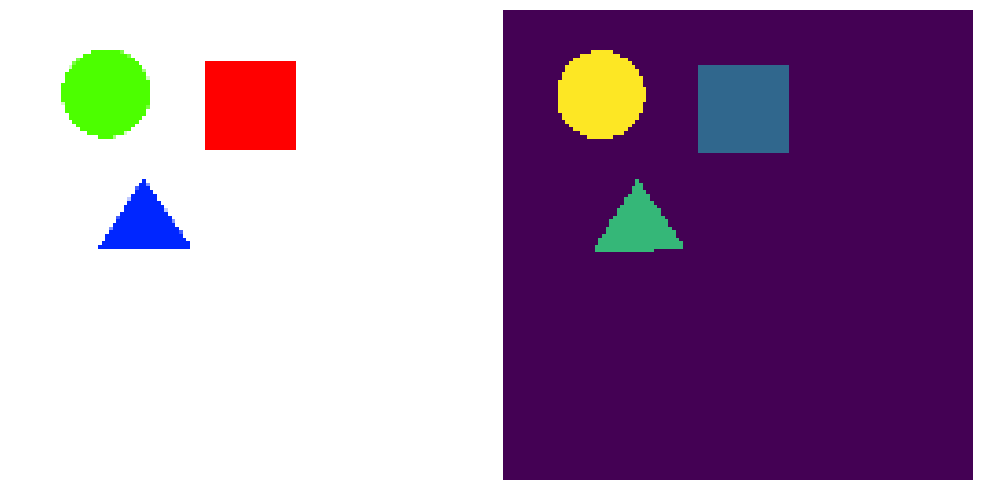

In [2]:
img, label = dataset.load_sample()
target_size = 128
#h,w = img.shape[:2]

resized_img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_LINEAR)
resized_label = cv2.resize(label, (target_size, target_size), interpolation=cv2.INTER_NEAREST)

target = dataset.convert_2_target(resized_label)
plot2(resized_img, resized_label)

### Explore center map

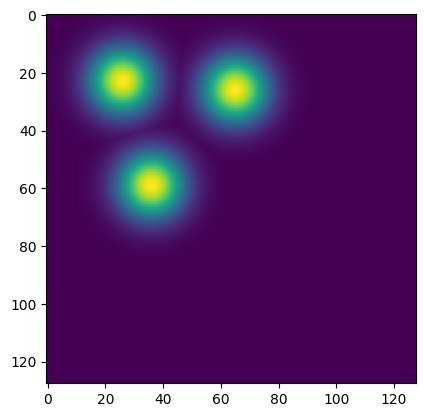

In [3]:
center_map = target["center"].numpy()
plt.imshow(center_map[0])

### Explore offset map

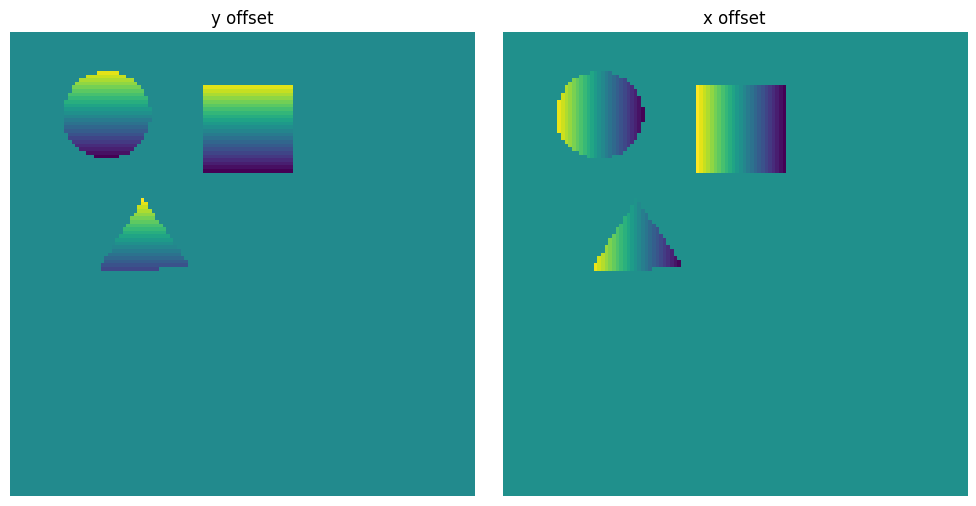

torch.Size([2, 128, 128])


In [4]:
offset_map = target["offset"].numpy()
plot2(offset_map[0], offset_map[1], ["y offset","x offset"])

print(target["offset"].shape)

### Explore post-processing

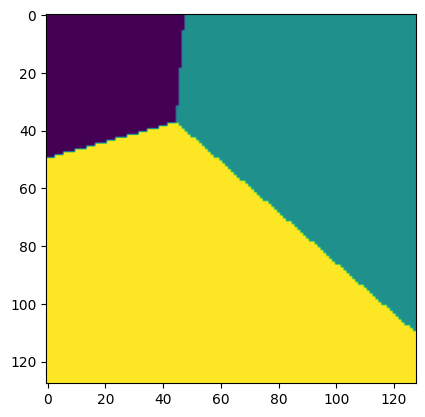

In [14]:
from src.post_processing import get_instance_segmentation

instance, center = get_instance_segmentation(
    target["center"],
    target["offset"]
)
plt.imshow(instance[0])

## Load model

In [15]:
from src.model.build_sam_encoder import sam_encoder_model_registry
from src.model.smm import SMM

sam_enc_checkpoint = "weights/sam_vit_b_01ec64_encoder.pth"
model_type = "vit_b_encoder"

# load SAM encoder
device = "cpu"
sam_encoder = sam_encoder_model_registry[model_type](checkpoint=sam_enc_checkpoint)

# create SMM model
smm = SMM(sam_encoder)
smm.to(device=device)

SMM(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [6]:
smm.parameters()

<generator object Module.parameters at 0x71331e9922e0>

torch.Size([1, 1, 128, 128])
torch.Size([1, 2, 128, 128])


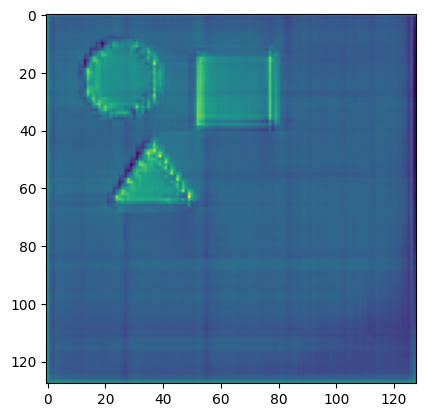

In [19]:
center_pred, offset_pred = smm._forward(img)
print(center_pred.shape)
print(offset_pred.shape)
plt.imshow(center_pred[0].detach().cpu().numpy())

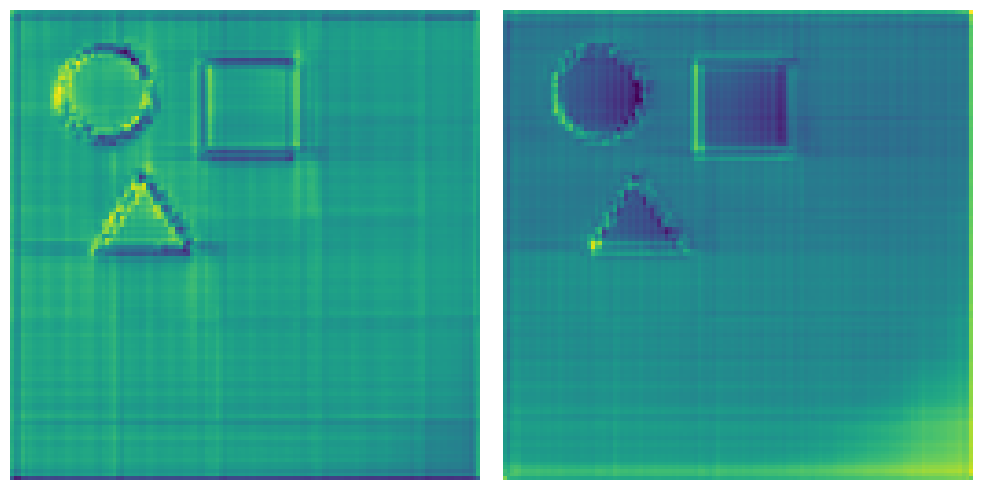

In [20]:
offset_pred_np = offset_pred[0].detach().cpu().numpy()
plot2(offset_pred_np[0], offset_pred_np[1])

### Train model

In [21]:
import torch
from torch import nn

center_loss = nn.MSELoss(reduction="none")
offset_loss = nn.L1Loss(reduction="none")

center_targets = torch.stack([target["center"].to(smm.device)])
center_weights = torch.stack([target["center_weights"].to(smm.device)])
offset_targets = torch.stack([target["offset"].to(smm.device)])
offset_weights = torch.stack([target["offset_weights"].to(smm.device)])

def center_losses(predictions, targets, weights, center_loss, center_loss_weight=1):
    loss = center_loss(predictions, targets) * weights
    if weights.sum() > 0:
        loss = loss.sum() / weights.sum()
    else:
        loss = loss.sum() * 0
    losses = {"loss_center": loss * center_loss_weight}
    return losses

def offset_losses(predictions, targets, weights, offset_loss, offset_loss_weight=1):
    loss = offset_loss(predictions, targets) * weights
    if weights.sum() > 0:
        loss = loss.sum() / weights.sum()
    else:
        loss = loss.sum() * 0
    losses = {"loss_offset": loss * offset_loss_weight}
    return losses

# AdamW optimizer
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, smm.parameters()), 
    lr=1e-3, weight_decay=1e-2)

# print(torch.max(center_targets), torch.min(center_targets))
# print(torch.max(center_weights), torch.min(center_weights))
# print(torch.max(offset_targets), torch.min(offset_targets))
# print(torch.max(offset_weights), torch.min(offset_weights))
epochs = 100
smm.train()
for epoch in range(epochs):
    
    total_loss = 0.0
    optimizer.zero_grad()
    
    center_pred, offset_pred = smm._forward(img)
    
    cl = center_losses(center_pred, center_targets, center_weights, center_loss, 200.0)
    ol = offset_losses(offset_pred, offset_targets, offset_weights, offset_loss, 0.05)


    loss = cl["loss_center"] + ol["loss_offset"]
    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

    total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/10:.4f}")
    print(cl, ol)

Epoch [1/100], Loss: 7.6532
{'loss_center': tensor(75.9958, grad_fn=<MulBackward0>)} {'loss_offset': tensor(0.5365, grad_fn=<MulBackward0>)}
Epoch [2/100], Loss: 4.0423
{'loss_center': tensor(39.8903, grad_fn=<MulBackward0>)} {'loss_offset': tensor(0.5326, grad_fn=<MulBackward0>)}
Epoch [3/100], Loss: 1.7763
{'loss_center': tensor(17.2342, grad_fn=<MulBackward0>)} {'loss_offset': tensor(0.5288, grad_fn=<MulBackward0>)}
Epoch [4/100], Loss: 0.7681
{'loss_center': tensor(7.1565, grad_fn=<MulBackward0>)} {'loss_offset': tensor(0.5249, grad_fn=<MulBackward0>)}
Epoch [5/100], Loss: 0.7590
{'loss_center': tensor(7.0689, grad_fn=<MulBackward0>)} {'loss_offset': tensor(0.5211, grad_fn=<MulBackward0>)}
Epoch [6/100], Loss: 1.2937
{'loss_center': tensor(12.4194, grad_fn=<MulBackward0>)} {'loss_offset': tensor(0.5172, grad_fn=<MulBackward0>)}
Epoch [7/100], Loss: 1.8647
{'loss_center': tensor(18.1335, grad_fn=<MulBackward0>)} {'loss_offset': tensor(0.5134, grad_fn=<MulBackward0>)}
Epoch [8/100], 

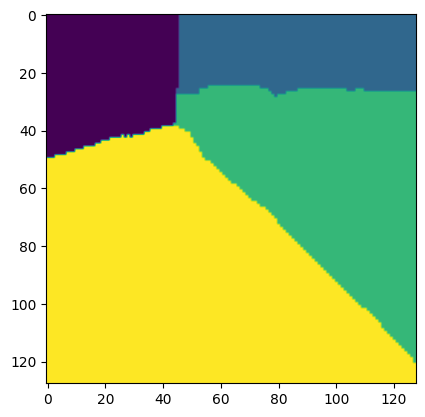

In [33]:
instance, center = get_instance_segmentation(
    center_pred[0],
    offset_pred[0],
    threshold=0.5, nms_kernel=7
)


plt.imshow(instance[0])

### Visualize predictions

torch.Size([1, 1, 128, 128])
torch.Size([1, 2, 128, 128])


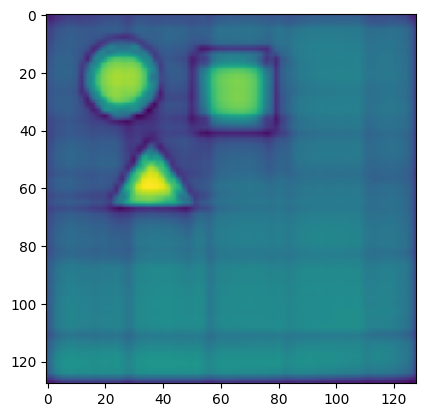

In [24]:
center_pred, offset_pred = smm._forward(img)
print(center_pred.shape)
print(offset_pred.shape)
plt.imshow(center_pred[0,0].detach().cpu().numpy())

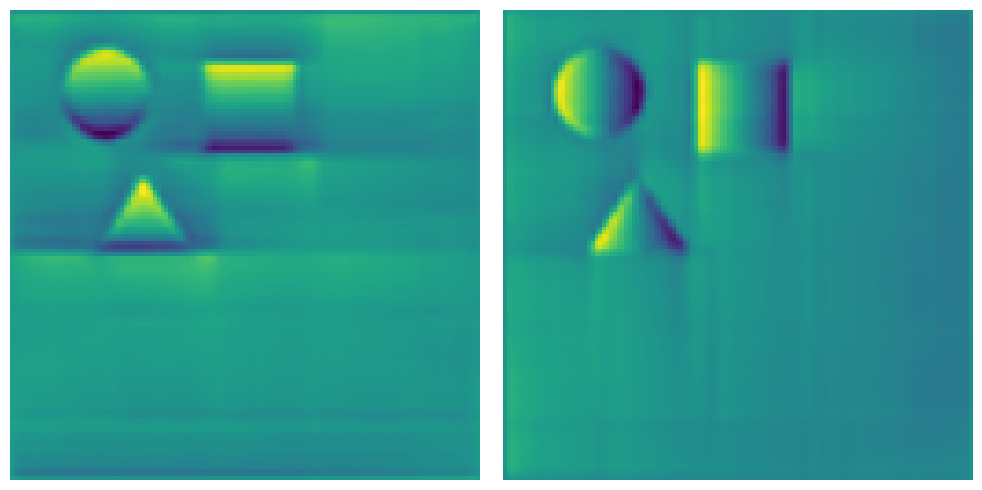

In [23]:
offset_pred_np = offset_pred[0].detach().cpu().numpy()
plot2(offset_pred_np[0], offset_pred_np[1])